# Implementing a Digital Reverberator 

## Reverberation

Real life reverberation refers to a high density of echoes occuring due to phase differences in waves due to reflection and absorbtion off of materials. An example of reverberation would be clapping in an empty theatre, and the reflections of the clap would be what we call "reverb" on the clap. Reverb is distinct from an echo, reverb refers to closely spaced reflections in time, like a pulse train. 

Often in audio engineering reverberation is a desired effect which producers want to add to a vocal layer or an instrument to create a "spacey" sound. Digitally, a simple echo is usually implemented with either an all pass filter, or a comb filter. 

A simple feedforward comb filter is implemented as follows: 

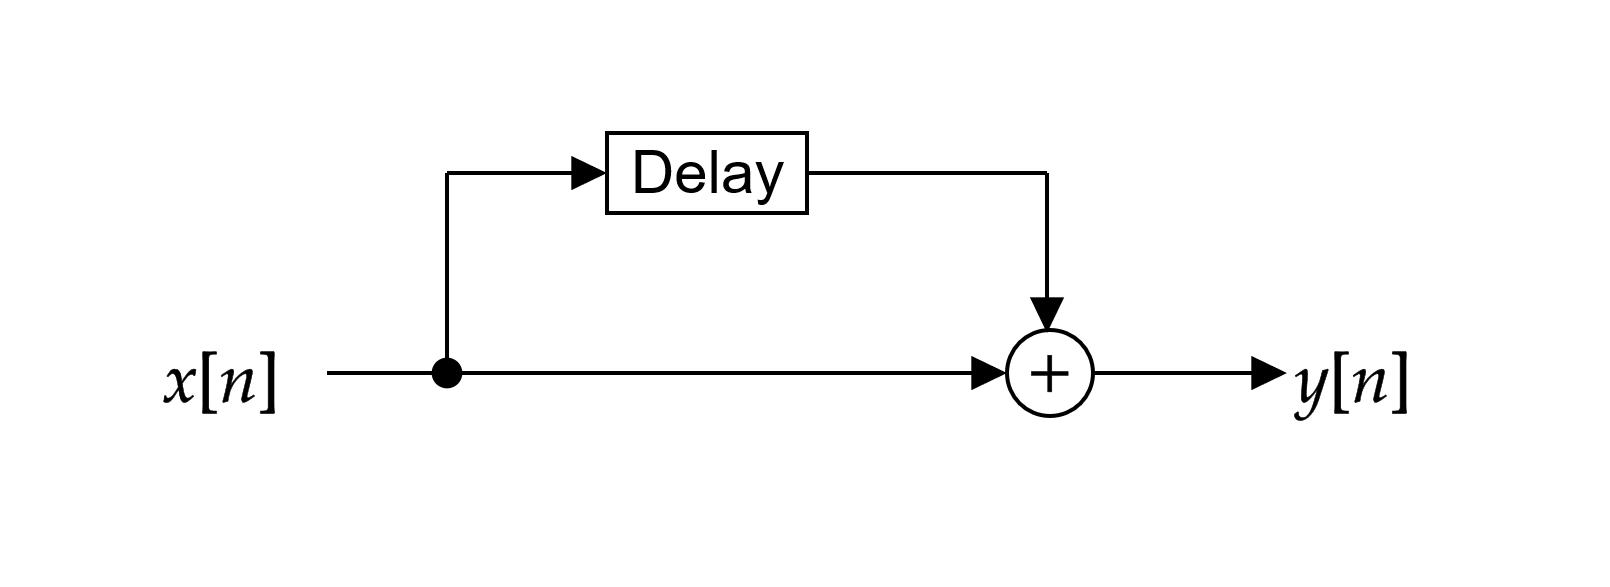

Assuming the phase delay is $T$, then the difference equation for this filter is

$$y[n] = x[n] + \alpha x[n-T] $$ 

where $\alpha$ is a linear gain applied to the delayed signal. By setting $\alpha =1$ we can see that we have implemented an echo on any input $x[n]$. But we want to simulate the effect of many reflections (as in the case of clapping in the empty lecture theatre), and this only describes one echo. Before proceeding with reverberation design, let's take a look at the transfer function which describes this system. By taking the $Z$ transform of the difference equation we obtain 

$$Y(z) = X(z) + \alpha z^{-T} X(z) \Longrightarrow H(z) = \frac{Y(z)}{X(z)} = 1 + \alpha z^{-T} = \frac{\alpha + z^T}{z^T}  $$ 

Again for the purposes of generating a pure echo, we set $\alpha =1$ and to investigate the frequency response we restrict $z=e^{j\omega}$:

$$H(e^{j\omega}) = \frac{1+e^{j\omega T}}{e^{j\omega T}} $$

We wish to look at the magnitude and phase response of such a filter. Let's assume that the delay is one unit: $T=1$. The following libraries will be used throughout this notebook: 

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
from scipy.io import wavfile 
import IPython 

With these libraries lets begin by looking at the magnitude and phase response of the comb filter in Python for different delay times, $T$.

<ipython-input-2-f29378b10565>:4: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H = np.zeros(N, dtype = np.complex)


Text(0.5, 0, 'Angular Frequency')

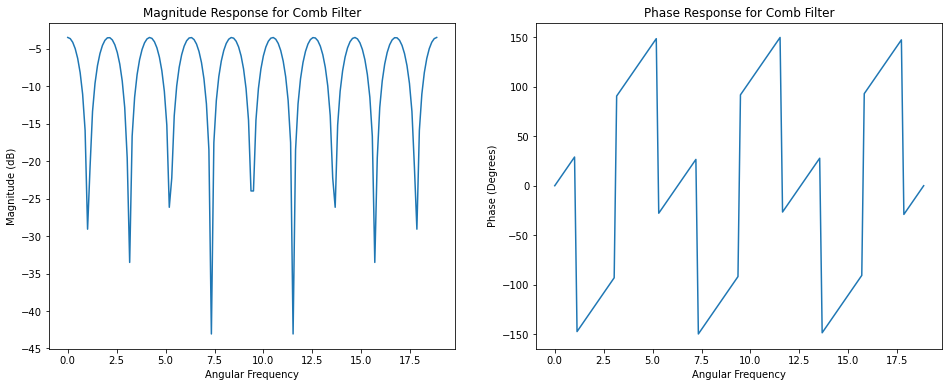

In [2]:
N = 150 # Number of samples
w = np.linspace(0, 6*np.pi, N) # Generate frequency axis 

H = np.zeros(N, dtype = np.complex)



    
for k in range(0, N):
    
    H[k] = (1+np.exp(3*w[k]*1j))/(3*np.exp(w[k]*1j))
    


Magnitude_Resp = np.abs(H)
Phase_Resp = np.angle(H)*180/np.pi

Magnitude_dB = 20*np.log10(Magnitude_Resp)


# Waterfall plot -- Do this in the future

#fig = plt.figure()
#ax = fig.add_subplot(111, projection = '3d')
#plt.set_cmap('jed_r')

# -- Plotting stuff: 
figs, axs = plt.subplots(1, 2, figsize = (16,6))

axs[0].plot(w, Magnitude_dB)
axs[0].set_title('Magnitude Response for Comb Filter')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].set_xlabel('Angular Frequency')

axs[1].plot(w, Phase_Resp)
axs[1].set_title('Phase Response for Comb Filter')
axs[1].set_ylabel('Phase (Degrees)')
axs[1].set_xlabel('Angular Frequency')


We can see that this filter has periodic "nulls", meaning at certain frequencies, periodically spaced, the filter attenuates them deeply. The magnitude response is what gives this filter the name "comb filter". Conceptually we can imagine that at the nulls, waves of that frequency will deconstructively interfere and otherwise we have constructive interference. Or we could imagine this response describes a room made of many composite materials, and frequencies at the nulls would get absorbed by the room. 

Before applying the filter we need to consider how to pick a value of $T$. This value of $T$ is measured in samples, which means that to get a noticable delay we need to pick $T$ on the order of milliseconds or greater. Typically audio is sampled at a rate of $f_s = 44100\,\text{samples}/\text{s}$. This means that the time duration of one sample is

$$\tau_\text{sample} = \frac{1}{f_s} $$ 

and if we have $N$ samples the total time of the signal is 

$$\tau_\text{signal} = \frac{N}{f_s}$$ 

In order to pick a sensible $T$, the value of $\tau_\text{sample}$ should be calculated and then multiplied to give a substantial delay. 

In [3]:
# -- Read in data 
fs, data = wavfile.read('githubsample.wav')

# -- Convert data to mono: Stereo implementation is something to do in the future

data = np.mean(data, axis = -1)

# -- Find largest audio component in the song 
max_vol = int(np.amax(data)) 

N = np.size(data)
T = int(8252) # 


def comb_filter(x, N, T):
    
    combed_data = np.zeros(N, dtype = np.float32)
    
    # Filter Formula: y[n] = x[n] + x[n-T]
    # Inital state of filter (x[k] = 0 if k<0)
    
    for k in range(0, N):
        
        if k < T:
            
            combed_data[k] = x[k]
        
        if k >= T:
            
            combed_data[k] = x[k] + 0.6*x[k-T]
    
    
    return combed_data


# -- Need to smooth out audio to reduce clipping present from the combing filter 
# -- Addition in the sequence x[k] + alpha*x[k-T] causes overflow and leads to audio clipping
def clip_stomper(data, N, peak):
    
    no_clipped_data = data
    
    for n in range(0, N):
        
        # -- Important that abs is used. Audio files can have negative components. 
        if abs(data[n]) > peak:
            
            # -- First solution for clipping reduction -- unlikely the best solution   
            if data[n] < 0:
                
                  
                no_clipped_data[n] = data[n] + (abs(data[n] - peak))/2
                
            if data[n] > 0:
                
                no_clipped_data[n] = data[n] - (data[n] - peak)/2
            
    
    return no_clipped_data 


filtered_audio = clip_stomper(comb_filter(data, N, T), N, max_vol)

# print(np.amax(new), np.max(data), np.size(data), k)

# -- Write new audio 
wavfile.write('githubsample_filtered.wav', fs, filtered_audio)

# -- Display new audio
IPython.display.Audio('githubsample_filtered.wav')

<ipython-input-3-a9e0190859b9>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read('githubsample.wav')


We can see from the audio output that an echo was generated (if the value of $T$ is increased large enough the echoes per second increases). One echo however is not reverberation. Reverberation would consist of many signals arriving at your ear at slightly different times. We can digitally simulate reverberation by using many combing filters. Each combing filter representing a slight deviation in phase for the incoming signal. Ideally we'd want hundreds of echoes per second to simulate genuine reverberation. To do this we would need to have each filter combined in a **parallel** combination so the signals can be processed simultaneously to produce many echoes of different phases which are closely spaced out in time. This method was first done by Manfred Schroeder in 1962 at Bell Labs and his [original paper](http://www2.ece.rochester.edu/~zduan/teaching/ece472/reading/Schroeder_1962.pdf) was a large part of the inspiration for this notebook and some insights into the design I surely never would have arrived at my own (using a series all-pass cascade was something I never considered for example.) 

How can we construct parallel comb filters? 

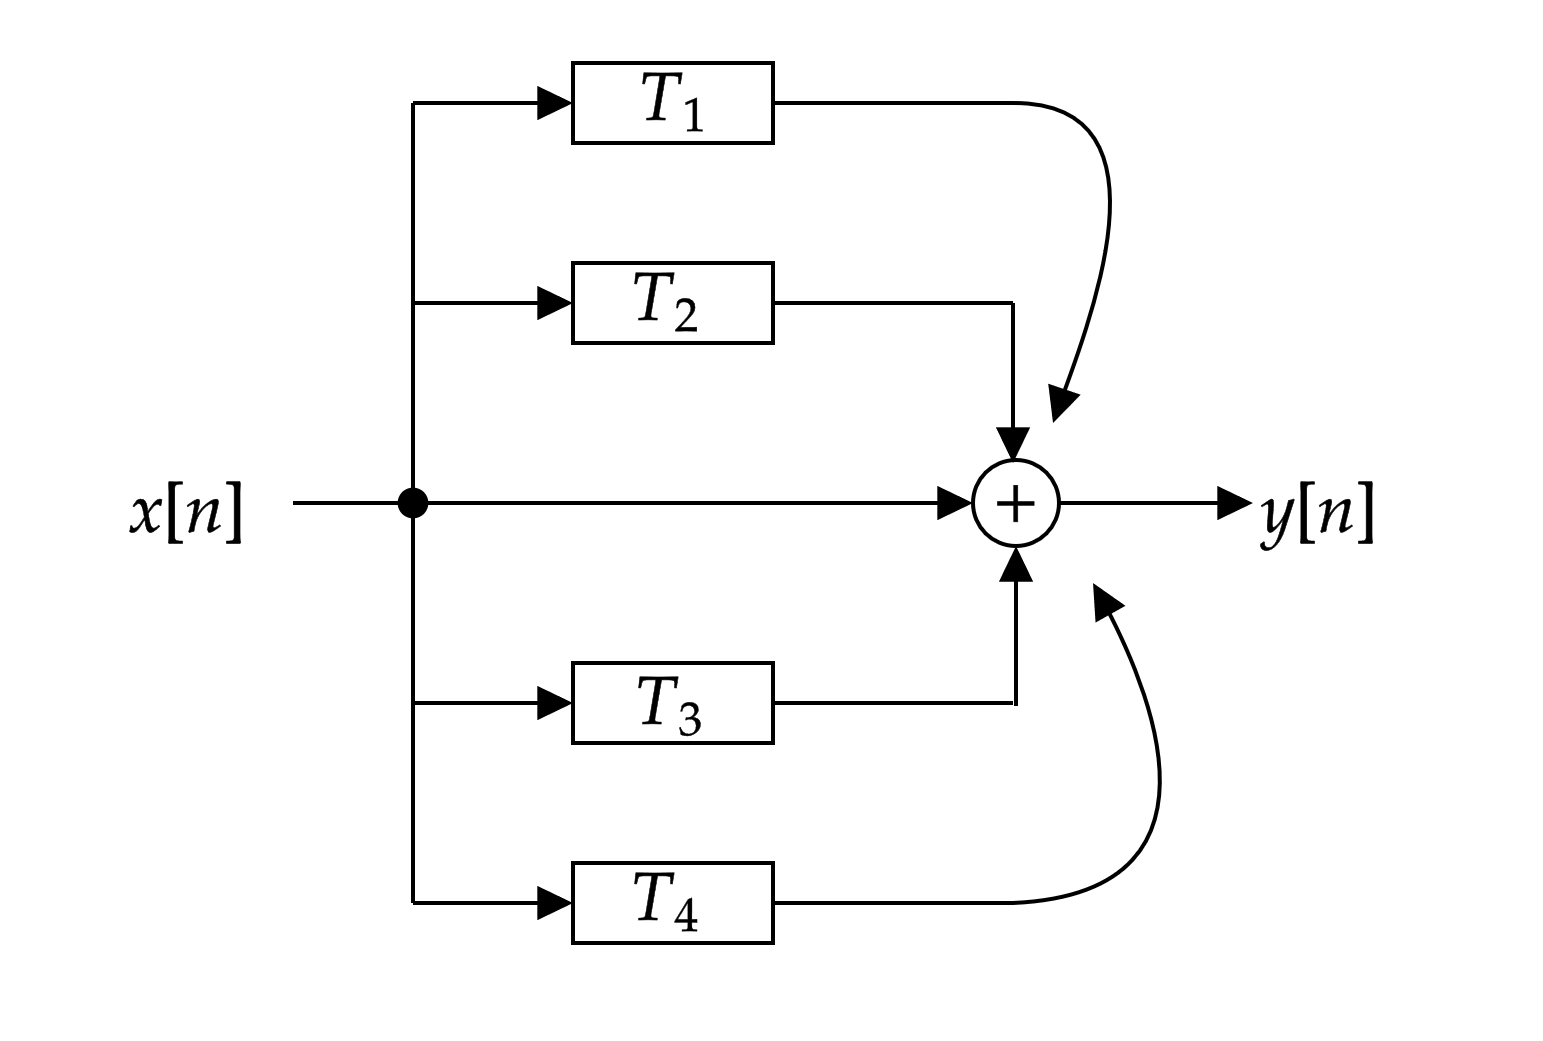

From the parallel connection above we see the following difference equation describes the filter:

$$y[n] = a_0x[n] + a_1x[n-T_1] + a_2x[n-T_2] + a_3x[n-T_3] + a_4x[n-T_4]  $$ 

**TODO: [Parallel programming](https://www.machinelearningplus.com/python/parallel-processing-python/)? Probably overkill but it would be fun to try**  

In [4]:
def reverb_filter(x, N, T, A):
    
    # Formula y[n] = a_0 x[n] + a_1 x[n-T_1] + a_2 x[n-T_2] + a_3 x[n-T_3] + a_4 x[n-T_4]
    # Initial state: x[n] = y[n] = 0 if n < 0
    
    reverbed_data = np.zeros(N, dtype = np.float32)
    
    T_1, T_2, T_3, T_4 = T[0], T[1], T[2], T[3]
    a_1, a_2, a_3, a_4 = A[0], A[1], A[2], A[3]
   
    for n in range(0, N):
        
        if n < T_1:
            
            reverbed_data[n] = x[n]
           
        if (n < T_2) and (n >= T_1): 
            
            reverbed_data[n] = x[n] + a_1*x[n-T_1]
        
        if (n < T_3) and (n >= T_2):
            
            reverbed_data[n] = x[n] + a_1*x[n-T_1] + a_2*x[n-T_2]
            
        if (n < T_4) and (n >= T_3):
            
            reverbed_data[n] = x[n] + a_1*x[n-T_1] + a_2*x[n-T_2] + a_3*x[n-T_3]
            
        if n >= T_4:
        
            reverbed_data[n] = x[n] + a_1*x[n-T_1] + a_2*x[n-T_2] + a_3*x[n-T_3] + a_4*x[n-T_4]
        
        
    return reverbed_data


# -- Store an array of tuples of the form (T_i, a_i) where y(n) = a_0 x(n) + a_1 x(n-T_1) +...+

P = np.array([ (200, 0.55), (400, 0.48), (600, 0.43), (800, 0.38)] )

P = sorted(P, key = lambda tup: tup[0]) # Organize tuples by ascending order of phase shift with lambda magic

Q = np.array([ P[0], P[1], P[2], P[3] ]) # Make it a numpy array again 

# -- Extract single arrays from multi-dimensional array to improve computational time and improve readability 

T = np.array([ Q[0][0], Q[1][0], Q[2][0], Q[3][0] ], dtype = np.int32)
A = np.array([ Q[0][1], Q[1][1], Q[2][1], Q[3][1] ])


# -- Write new audio 
wavfile.write('githubsample_filtered.wav', fs, clip_stomper(reverb_filter(data, N, T, A), N, max_vol))

# -- Display new audio
IPython.display.Audio('githubsample_filtered.wav')

We can hear more echoes with four combing filters implemented, however this still isn't a reverb effect. This is because even four combing filters together will not produce enough echoes to produce a reverberation effect. However, all is not lost. This is the only first half of a working simple reverberator. The other half consists of two all pass filters in series. You may ask: What is the point of an all pass filter? Why would we want to pass something through a filter which will not edit any frequency content at all? The answer is straightforward to understand: The comb filters each create a certain amount of echoes per second at different delays, then by passing these echoes through an all-pass filter with an additional delay will cause echoes on the echoes, and then passing these into another all-pass filter will cause echoes on the echoes which echoed off the echoes. A cascading effect of echo production will cause the density of echoes to increase to produce a digital reverberator. 

In [5]:
def all_pass(x, T, N, g):
    
    all_passed_data = np.zeros(N, dtype = np.float32)
    
    for n in range(0, N):
        
        if n < T:
            
            all_passed_data[n] = -g*x[n] 
            
        if n >= T:
            
            all_passed_data[n] = -g*x[n] + x[n-T] + g*all_passed_data[n-T]
            
            
    return all_passed_data

# -- The all pass filters were recommended to have delays of approx 5 and 1.7ms and the same gain around 0.7
T_ap1 = 280
T_ap2 = 180
#T_ap3 = 80

g_ap = 0.7

combed_audio = clip_stomper(reverb_filter(data, N, T, A), N, max_vol)

filtered_audio = all_pass(all_pass(combed_audio, T_ap1, N, g_ap), T_ap2, N, g_ap)

#filtered_audio = all_pass(filtered_audio, T_ap3, N, g_ap)

# -- Write new audio 
wavfile.write('githubsample_filtered.wav', fs, filtered_audio)

# -- Display new audio
IPython.display.Audio('githubsample_filtered.wav')

The final result here is quite a metallic reverb, it sounds much more like someone speaking through a tube or tunnel than a nice reverb that one would usually want to put onto an audio layer. The audio still has some artifacts that need to be corrected as well. 

This reverb design was the first digital reverb design ever, and there can be modifications made to it to improve performance. But for now this is where I stop as generally this type of reverberator is quite metallic. I believe in the paper cited above, and in other literature on this specific digital reverberator there are optimal formulas for phase shifts and gains. 

**TODO:** There is artifacts in the audio from the reverb filter. This is most likely due to the delay values in the comb filter feed back lines. It's possible that the same audio chunk is being reflected at nearly the same time causing a popcorn sound effect in the audio. 